In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

In [26]:
df = df_ = pd.read_csv(filepath_or_buffer="C:\\Lib\\fifa_players.csv")
df = df_.copy()

In [27]:
from sklearn.preprocessing import LabelEncoder
df = df.drop(columns=['full_name','name','birth_date','nationality'])

categorical_to_nums = {'preferred_foot'  :   {'Left'  : 0, 'Right' : 1,},
                       'body_type'  :   {'Lean'  : 0, 'Normal' : 1, 'Stocky' : 2}} 
for column, mapping in categorical_to_nums.items():
    temp_series = df[column].copy()
    null_mask = temp_series.isnull()
    temp_series.loc[~null_mask] = temp_series.loc[~null_mask].map(mapping) 
    df[column] = temp_series.fillna(-1).astype('int64')

df['positions'] = df['positions'].str.split(',').str[0]   


for column in ['height_cm','value_euro','wage_euro','release_clause_euro' ]:   
    df[column] = df.groupby('positions')[column].transform(lambda x: x.fillna(x.median()))
    
    
    
df = df.drop(columns=['national_team','national_team_position','national_jersey_number','national_rating'])


encoder = LabelEncoder()

df['positions_encoded'] = encoder.fit_transform(df['positions'])


df = df.drop(columns=['positions'])

C:\Users\redoe\AppData\Local\Temp\ipykernel_4752\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')
C:\Users\redoe\AppData\Local\Temp\ipykernel_4752\3583185044.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = temp_series.fillna(-1).astype('int64')


In [28]:
X = df.drop(columns=['value_euro'])


y = df['value_euro']
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.20)

In [29]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X,y)
mutual_info = pd.Series(mutual_info, index=X.columns)

In [30]:
from sklearn.feature_selection import SelectPercentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=20)
selected_top_columns.fit(X_train,y_train)

SelectPercentile(percentile=20,
                 score_func=<function mutual_info_regression at 0x0000014AF1FB8360>)

In [31]:
X_train = pd.DataFrame(selected_top_columns.transform(X_train), 
                     columns=X_train.columns[selected_top_columns.get_support()], 
                     index=X_train.index)

X_test = pd.DataFrame(selected_top_columns.transform(X_test), 
                    columns=X_test.columns[selected_top_columns.get_support()], 
                    index=X_test.index)

In [32]:
def shorten_number(x, pos):
    if x >= 1_000_000_000:
        return f'{x / 1_000_000_000:.2f}B'  # Milyar
    elif x >= 1_000_000:
        return f'{x / 1_000_000:.2f}M'  # Milyon
    elif x >= 1_000:
        return f'{x / 1_000:.2f}K'  # Bin
    else:
        return str(x)

C:\Users\redoe\AppData\Local\Temp\ipykernel_4752\2806250397.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(y_test,svr_preds_abs,'ro',color='blue', markerfacecolor='red',markersize='1')


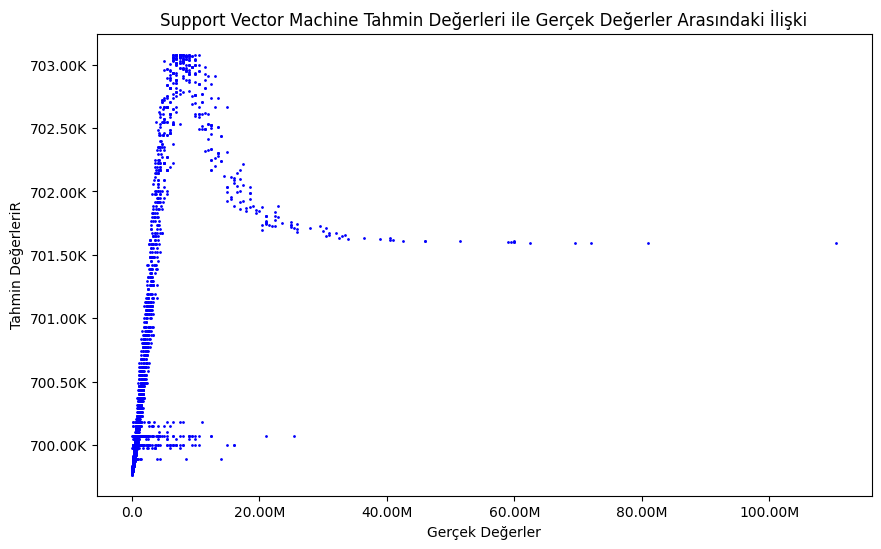

{'Mean Squared Error': 35408575729490.89, 'Root Mean Squared Error': 5950510.5435996745, 'Mean Absolute Error': 2104670.810207755, 'Cross Validation': array([-0.1174199 , -0.08504698, -0.10852839, -0.13416562, -0.08251837,
       -0.09969851, -0.0802498 , -0.1001538 , -0.09987339, -0.0909663 ]), 'R2 Score': -0.0941841995020245}


In [33]:
svr_regressor = SVR(kernel='rbf',C=1) # default 
svr_regressor.fit(X_train, y_train)
svr_preds = svr_regressor.predict(X_test)
svr_preds_abs = abs(svr_preds)
svr_train_score = svr_regressor.score(X_train, y_train)
svr_test_score = svr_regressor.score(X_test, y_test)

mse = mean_squared_error(y_test, svr_preds)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, svr_preds)
cross_val = cross_val_score(svr_regressor, X_train, y_train, cv=10)
r2 = r2_score(y_test, svr_preds)
svr_values = {'Mean Squared Error'       :   mse,
                     'Root Mean Squared Error'  :   rmse,
                     'Mean Absolute Error'      :   mae,
                     'Cross Validation'         :   cross_val,
                     'R2 Score'                 :   r2}


plt.figure(figsize=(10,6))
plt.plot(y_test,svr_preds_abs,'ro',color='blue', markerfacecolor='red',markersize='1')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(shorten_number))
plt.title("Support Vector Machine Tahmin Değerleri ile Gerçek Değerler Arasındaki İlişki")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin DeğerleriR")
plt.show()

print(svr_values)